In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import copy
from ast import Param
import json
import math

from utils.prune import prune_weights
from utils.count_improvement import improvements
from utils.normalize import normalize_weights

In [2]:
# Verificar si la GPU está disponible y establecer el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Definimos las redes

In [4]:
net = Net().to(device)
varianzas_net = Net().to(device)

In [5]:
def pesos_mas_altos(red):
    pesos_altos = {}

    for nombre_capa, param in red.named_parameters():
        if 'weight' in nombre_capa:  # Solo considerar los pesos
            # Aplanar la matriz de pesos para obtener el peso más alto global
            max_valor, indice = torch.max(param.data.abs().flatten(), dim=0)  # Valor absoluto
            pesos_altos[nombre_capa] = (max_valor.item(), indice.item())

    return pesos_altos

# Obtener los pesos más altos de cada capa
resultado = pesos_mas_altos(net)  # Cambia 'net' por 'red' si has definido la red como 'red'

# Mostrar resultados
for capa, (valor, indice) in resultado.items():
    print(f"Capa: {capa}, Peso más alto: {valor}, Índice: {indice}")


Capa: fc1.weight, Peso más alto: 0.03571421280503273, Índice: 99409
Capa: fc2.weight, Peso más alto: 0.06249988079071045, Índice: 6313
Capa: fc3.weight, Peso más alto: 0.08835174888372421, Índice: 168


Cargamos los datos

In [6]:
# Definimos el transform para los datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargamos el dataset de MNIST
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Definimos los DataLoaders para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

In [7]:
# Definimos la función de pérdida para calcular el error
criterion = nn.CrossEntropyLoss()

In [8]:
# train loop
train_loss = []
test_accuracies = []
epoch = 1
accuracy_threshold = 0.4
best_loss = 100000 # Inicializamos con un valor muy alto para que el primer valor sea mas bajo

#normalizamos varianzas
for layer in varianzas_net.modules():
    if isinstance(layer, nn.Linear):
        fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)
        normalize_weights(layer, lower_bound=math.sqrt(1/fan_in)*0.9, upper_bound=math.sqrt(1/fan_in))

while True:
    print(f"Epoch {epoch}")
    if epoch <= 9:

        for layer in net.modules():
            if isinstance(layer, nn.Linear):
                fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)
                normalize_weights(layer, lower_bound=math.sqrt(1/fan_in)*0.01, upper_bound=math.sqrt(1/fan_in))

        state_dict_red1 = net.state_dict()
        state_dict_red2 = varianzas_net.state_dict()

        # Crear un nuevo diccionario de estado donde sumamos los pesos
        state_dict_suma = {}
        for key in state_dict_red1:
            if state_dict_red1[key].size() == state_dict_red2[key].size():  # Asegurar que las dimensiones coincidan
                # Asegurar que las desviaciones estándar sean positivas para generar el ruido
                std_dev = torch.abs(state_dict_red2[key])
                
                # Generamos los valores aleatorios con una distribución normal usando torch.normal
                noise = torch.normal(0, std_dev)
                
                # Aplicar la operación de suma
                state_dict_suma[key] = state_dict_red1[key] + noise
            else:
                # Si los tamaños no coinciden, copiamos directamente
                state_dict_suma[key] = state_dict_red1[key]

        # Crear una nueva red o modificar una existente con los pesos sumados
        varied_net = Net().to(device)
        varied_net.load_state_dict(state_dict_suma)

        pruned_net = prune_weights(varied_net)

        running_loss = 0.0
        # Pasamos todas las imagenes de train por la red net
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs_net = pruned_net(images)
            loss = criterion(outputs_net, labels)

            running_loss += loss.item()

        if running_loss < best_loss: # Guardamos los pesos de la red con menor pérdida
            best_loss = running_loss
            net.load_state_dict(state_dict_suma)

        train_loss.append(running_loss / len(train_loader))
        print(f"Train loss: {running_loss / len(train_loader)}")

        # Evaluamos el modelo en el conjunto de test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs_net = pruned_net(images)
                _, predicted = torch.max(outputs_net.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracies.append(correct / total)
        print(f"Test accuracy: {correct / total}")

        if correct / total > accuracy_threshold:
            break

    else:
        if epoch == 80: #Verificar pesos y varianzas
            state_dict_suma_serializable = {key: value.cpu().numpy().tolist() for key, value in state_dict_suma.items()}
            state_dict_var_serializable = {key: value.cpu().numpy().tolist() for key, value in state_dict_red2.items()}
            with open("pesos_epoca_80.txt", "w") as f:
                json.dump(state_dict_suma_serializable, f)
            with open("varianzas_epoca_80.txt", "w") as f:
                json.dump(state_dict_var_serializable, f)

        for layer in net.modules():
            if isinstance(layer, nn.Linear):
                fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)
                normalize_weights(layer, lower_bound=math.sqrt(1/fan_in)*0.01, upper_bound=math.sqrt(1/fan_in))

        # Sumamos los pesos de las redes en una red nueva
        state_dict_red1 = net.state_dict()
        state_dict_red2 = varianzas_net.state_dict()

        state_dict_suma = {}
        for key in state_dict_red1:
            if state_dict_red1[key].size() == state_dict_red2[key].size():  # Asegurar que las dimensiones coincidan
                # Asegurar que las desviaciones estándar sean positivas para generar el ruido
                std_dev = torch.abs(state_dict_red2[key])
                
                # Generamos los valores aleatorios con una distribución normal usando torch.normal
                noise = torch.normal(0, std_dev)
                
                # Aplicar la operación de suma
                state_dict_suma[key] = state_dict_red1[key] + noise
            else:
                # Si los tamaños no coinciden, copiamos directamente
                state_dict_suma[key] = state_dict_red1[key]

        # Crear una nueva red o modificar una existente con los pesos sumados
        varied_net = Net().to(device)
        varied_net.load_state_dict(state_dict_suma)

        pruned_net = prune_weights(varied_net)

        running_loss = 0.0
        # Pasamos todas las imagenes de train por la red net
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs_net = pruned_net(images)
            loss = criterion(outputs_net, labels)

            running_loss += loss.item()
        
        if running_loss < best_loss: # Guardamos los pesos de la red con menor pérdida
            best_loss = running_loss
            net.load_state_dict(state_dict_suma)

        train_loss.append(running_loss / len(train_loader))
        print(f"Train loss: {running_loss / len(train_loader)}")

        # Evaluamos el modelo en el conjunto de test
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                outputs_net = pruned_net(images)
                _, predicted = torch.max(outputs_net.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracies.append(correct / total)
        print(f"Test accuracy: {correct / total}")

        if correct / total > accuracy_threshold:
            break

        # actualizmos el vector de varianzas
        if improvements(train_loss) > 2:## +mejoras que peoras
            with torch.no_grad():
                for param in varianzas_net.parameters():
                    param *= (1/0.82)

        elif improvements(train_loss) < 2: ## -mejoras que peoras
            with torch.no_grad():
                for param in varianzas_net.parameters():
                    param *= 0.82
        
        else:
            pass

        #normalizamos varianzas
        for layer in varianzas_net.modules():
            if isinstance(layer, nn.Linear):
                fan_in, _ = init._calculate_fan_in_and_fan_out(layer.weight)
                normalize_weights(layer, lower_bound=math.sqrt(1/fan_in)*0.9, upper_bound=math.sqrt(1/fan_in))
    
    epoch += 1

Epoch 1
Train loss: 8.609486317075392
Test accuracy: 0.1061
Epoch 2
Train loss: 5.777278139138781
Test accuracy: 0.0701
Epoch 3
Train loss: 7.998498486049139
Test accuracy: 0.096
Epoch 4
Train loss: 5.566980278059872
Test accuracy: 0.1004
Epoch 5
Train loss: 7.242581439170756
Test accuracy: 0.0988
Epoch 6
Train loss: 7.7021181756245305
Test accuracy: 0.097
Epoch 7
Train loss: 6.0645290834308945
Test accuracy: 0.0973
Epoch 8
Train loss: 4.409734751624085
Test accuracy: 0.075
Epoch 9
Train loss: 6.4523705025471605
Test accuracy: 0.1675
Epoch 10
Train loss: 8.287453803426422
Test accuracy: 0.0234
Epoch 11
Train loss: 5.1362855513212775
Test accuracy: 0.0965
Epoch 12
Train loss: 8.543792568544335
Test accuracy: 0.021
Epoch 13
Train loss: 5.234491892714999
Test accuracy: 0.0707
Epoch 14
Train loss: 5.63031239016478
Test accuracy: 0.1835
Epoch 15
Train loss: 5.492597410927957
Test accuracy: 0.1104
Epoch 16
Train loss: 4.8284160862091
Test accuracy: 0.1385
Epoch 17
Train loss: 7.4457376577706

KeyboardInterrupt: 

In [9]:
print(max(test_accuracies))

0.2036


In [10]:
print(train_loss)

[8.609486317075392, 5.777278139138781, 7.998498486049139, 5.566980278059872, 7.242581439170756, 7.7021181756245305, 6.0645290834308945, 4.409734751624085, 6.4523705025471605, 8.287453803426422, 5.1362855513212775, 8.543792568544335, 5.234491892714999, 5.63031239016478, 5.492597410927957, 4.8284160862091, 7.445737657770674, 4.70526380147507, 5.932906994687468, 8.031024655299401, 6.815375680354104, 5.99245694298734, 4.153031895663947, 7.867167883590341, 6.9535626155226975, 7.063477194893843, 6.431400649328984, 5.103783506066052, 6.357159090194621, 6.31085215626495, 4.686867329357529, 7.773994584581745, 5.363535571454176, 6.4013291836293265, 7.878135567280784, 4.181157918372897, 6.392496743436053, 5.482854801708702, 10.688973722173207, 6.310059800585195, 6.7780928235572535, 5.983212585134039, 6.135548851129089, 6.53997666495187, 6.738703040425966, 5.826025152765611, 5.841593368475371, 11.657261321793742, 5.066864067557524, 6.023804611997055, 6.245173734388372, 6.548099910780819, 5.2426720

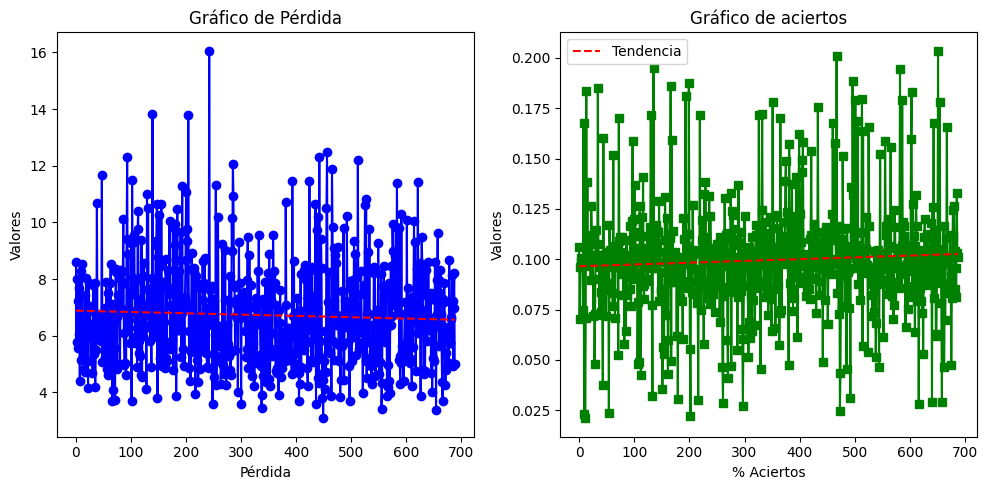

In [14]:
# Creamos la figura y definimos dos subgráficos (1 fila, 2 columnas)
plt.figure(figsize=(10, 5))

# Primer gráfico en la posición 1 (izquierda)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(train_loss, color='blue', marker='o')
plt.title("Gráfico de Pérdida")
plt.xlabel("Pérdida")
plt.ylabel("Valores")

# Calcular la regresión lineal para train_loss
epochs = np.arange(len(train_loss))
m, b = np.polyfit(epochs, train_loss, 1)
plt.plot(epochs, m*epochs + b, color='red', linestyle='--', label='Tendencia')


# Segundo gráfico en la posición 2 (derecha)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(test_accuracies, color='green', marker='s')
plt.title("Gráfico de aciertos")
plt.xlabel("% Aciertos")
plt.ylabel("Valores")

# Calcular la regresión lineal para test_accuracies
epochs_test = np.arange(len(test_accuracies))
m, b = np.polyfit(epochs_test, test_accuracies, 1)
plt.plot(epochs_test, m*epochs_test + b, color='red', linestyle='--', label='Tendencia')

# Mostramos los gráficos
plt.tight_layout()  # Ajustamos para que no se solapen los gráficos
plt.legend()
plt.show()